In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

## 이전 코드

In [2]:
# 경로 설정
full_dir = "/home/users/chaehyun/RS/A-LLMRec/pre_train/sasrec_multi/sports/user_repr"
sampled_dir = "/home/users/chaehyun/RS/A-LLMRec/pre_train/sasrec_multi/sports75/user_repr"

In [49]:
user_files = sorted(os.listdir(full_dir))  # ['123.pt', '456.pt', ...]

l2_distances = []
cosine_similarities = []
user_ids = []

for fname in tqdm(user_files):
    full_path = os.path.join(full_dir, fname)
    sampled_path = os.path.join(sampled_dir, fname)

    if not os.path.exists(sampled_path):
        continue  # 샘플링에 없는 유저는 스킵

    full_obj = torch.load(full_path, map_location="cuda:7", weights_only=False)
    sampled_obj = torch.load(sampled_path, map_location="cuda:7", weights_only=False)

    full_vec = full_obj["user_repr"] # torch.Size([1, 50])
    sampled_vec = sampled_obj["user_repr"]

    full_vec = full_vec.squeeze(0)
    sampled_vec = sampled_vec.squeeze(0)

    # L2 distance
    l2 = torch.norm(full_vec - sampled_vec, p=2).item()
    l2_distances.append(l2)

    # Cosine similarity (normalize 후 dim=0으로 정확히)
    full_vec = F.normalize(full_vec, dim=0)
    sampled_vec = F.normalize(sampled_vec, dim=0)
    cos_sim = F.cosine_similarity(full_vec, sampled_vec, dim=0).item()
    cosine_similarities.append(cos_sim)

    user_ids.append(full_obj["user_ids"])


# 통계 요약
print(f"[L2] mean: {np.mean(l2_distances):.4f}, std: {np.std(l2_distances):.4f}")
print(f"[Cosine Sim] mean: {np.mean(cosine_similarities):.4f}, std: {np.std(cosine_similarities):.4f}")

100%|██████████| 512/512 [00:00<00:00, 966.66it/s] 

[L2] mean: 12.6990, std: 0.6700
[Cosine Sim] mean: -0.0765, std: 0.1036


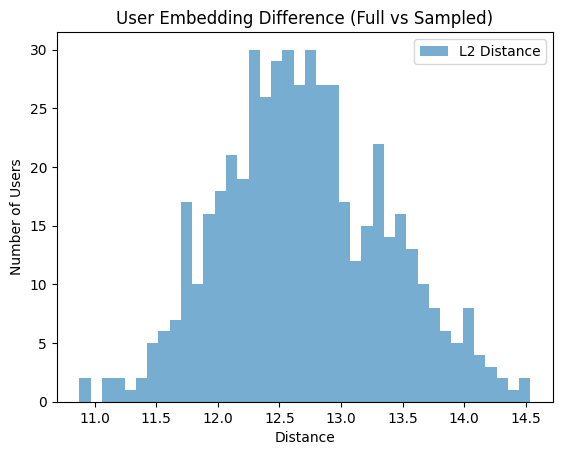

In [50]:
# 히스토그램 시각화
plt.hist(l2_distances, bins=40, alpha=0.6, label="L2 Distance")
plt.xlabel("Distance")
plt.ylabel("Number of Users")
plt.title("User Embedding Difference (Full vs Sampled)")
plt.legend()
plt.show()

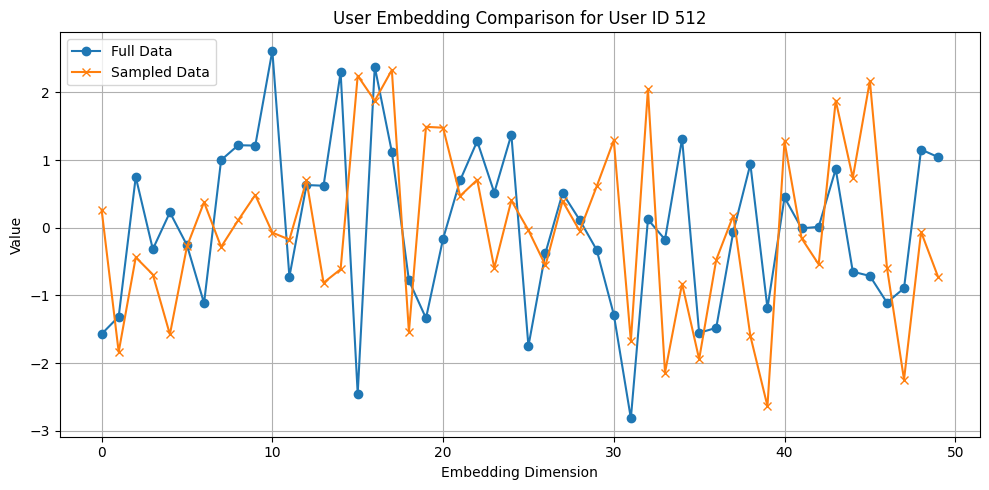

In [ ]:
import torch
import matplotlib.pyplot as plt
import os

user_id = "512"  # 비교할 유저 ID
full_path = os.path.join(full_dir, f"{user_id}.pt")
sampled_path = os.path.join(sampled_dir, f"{user_id}.pt")

full_obj = torch.load(full_path, map_location="cuda:7", weights_only=False)
sampled_obj = torch.load(sampled_path, map_location="cuda:7", weights_only=False)

full_vec = full_obj["user_repr"].squeeze()      # [50]
sampled_vec = sampled_obj["user_repr"].squeeze()  # [50]

# 시각화
plt.figure(figsize=(10, 5))
plt.plot(full_vec.cpu().numpy(), label="Full Data", marker='o')
plt.plot(sampled_vec.cpu().numpy(), label="Sampled Data", marker='x')
plt.title(f"User Embedding Comparison for User ID {user_id}")
plt.xlabel("Embedding Dimension")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 두개 비교

100%|██████████| 512/512 [00:00<00:00, 974.68it/s]


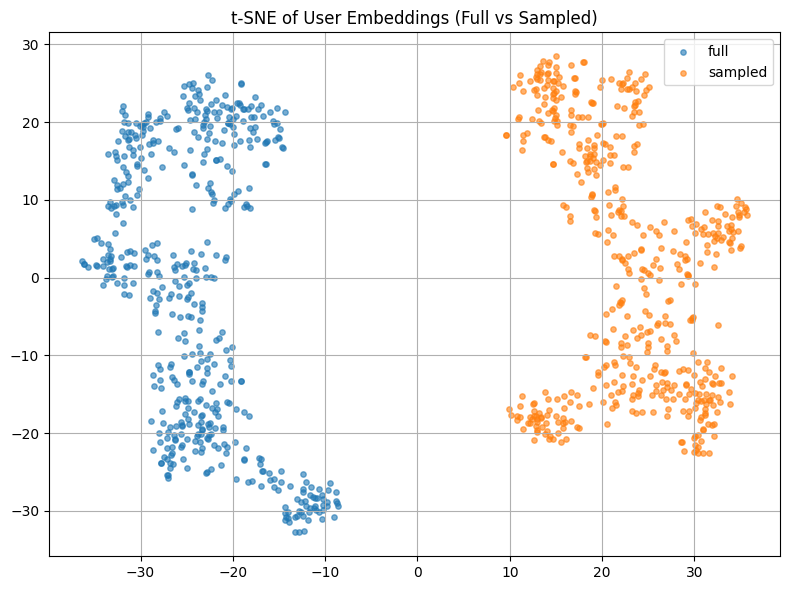

In [28]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE

# 경로 설정
full_dir = "/home/users/chaehyun/RS/A-LLMRec/pre_train/sasrec_multi/sports100/user_repr"
sampled_dir = "/home/users/chaehyun/RS/A-LLMRec/pre_train/sasrec_multi/sports75/user_repr"

user_files = sorted(os.listdir(full_dir))  # 예: ['123.pt', '456.pt', ...]

full_embeddings = []
sampled_embeddings = []
user_ids = []

for fname in tqdm(user_files):
    full_path = os.path.join(full_dir, fname)
    sampled_path = os.path.join(sampled_dir, fname)

    if not os.path.exists(sampled_path):
        continue

    full_obj = torch.load(full_path, map_location="cuda:7", weights_only=False)
    sampled_obj = torch.load(sampled_path, map_location="cuda:7", weights_only=False)

    full_vec = full_obj["user_repr"].squeeze(0)         # [1, d] -> [d]
    sampled_vec = sampled_obj["user_repr"].squeeze(0)   # [1, d] -> [d]

    full_vec = torch.nn.functional.normalize(full_vec, dim=0)
    sampled_vec = torch.nn.functional.normalize(sampled_vec, dim=0)

    full_embeddings.append(full_vec.cpu().numpy())
    sampled_embeddings.append(sampled_vec.cpu().numpy())
    user_ids.append(fname.split(".")[0])  # 예: "123"

# (2N, d)
all_embeddings = np.vstack([full_embeddings, sampled_embeddings])
labels = ["full"] * len(full_embeddings) + ["sampled"] * len(sampled_embeddings)

# t-SNE로 2D 투영
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(all_embeddings)

# 시각화
plt.figure(figsize=(8, 6))
for label in ["full", "sampled"]:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=label, alpha=0.6, s=15)

plt.title("t-SNE of User Embeddings (Full vs Sampled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


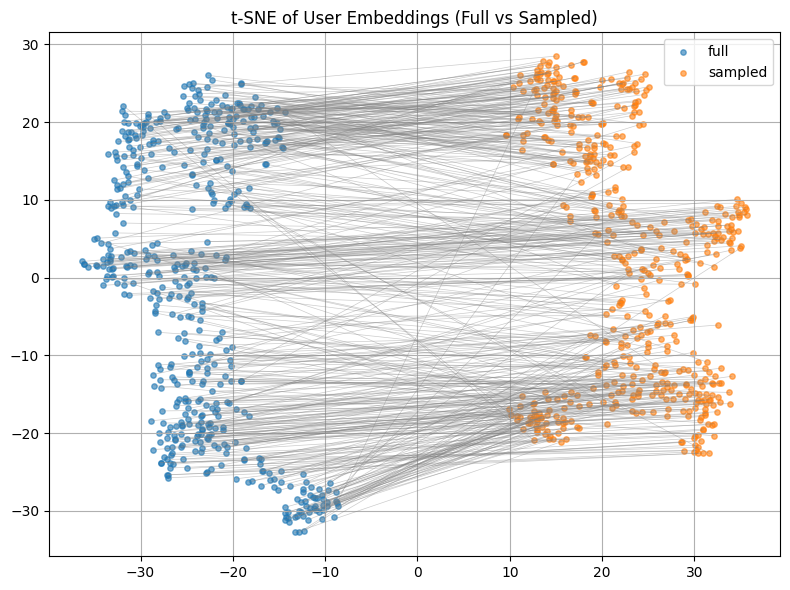

In [29]:
plt.figure(figsize=(8, 6))

# 먼저 scatter
for label in ["full", "sampled"]:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=label, alpha=0.6, s=15)

# 선 연결: 같은 user_id에 대해 full vs sampled 위치를 잇기
num_users = len(user_ids)
for i in range(num_users):
    x_coords = [tsne_result[i, 0], tsne_result[i + num_users, 0]]  # full, sampled
    y_coords = [tsne_result[i, 1], tsne_result[i + num_users, 1]]
    plt.plot(x_coords, y_coords, color="gray", alpha=0.4, linewidth=0.5)

plt.title("t-SNE of User Embeddings (Full vs Sampled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


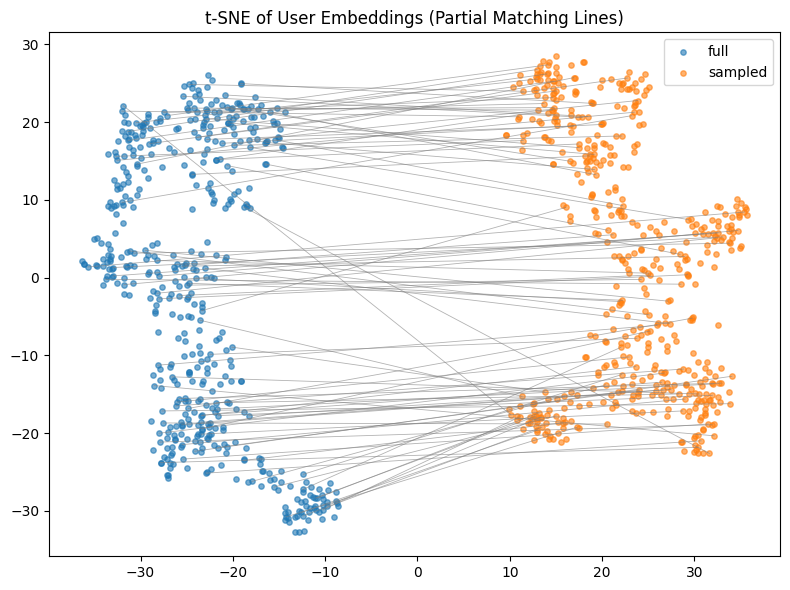

In [30]:
import random

plt.figure(figsize=(8, 6))

# 전체 scatter (full + sampled)
for label in ["full", "sampled"]:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=label, alpha=0.6, s=15)

# 선 연결: 일부 유저만
num_users = len(user_ids)
max_lines = 100  # 연결할 유저 수 제한

sampled_indices = random.sample(range(num_users), min(max_lines, num_users))
for i in sampled_indices:
    x_coords = [tsne_result[i, 0], tsne_result[i + num_users, 0]]  # full, sampled
    y_coords = [tsne_result[i, 1], tsne_result[i + num_users, 1]]
    plt.plot(x_coords, y_coords, color="gray", alpha=0.6, linewidth=0.6)

plt.title("t-SNE of User Embeddings (Partial Matching Lines)")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()


Procrustes disparity: 0.3424


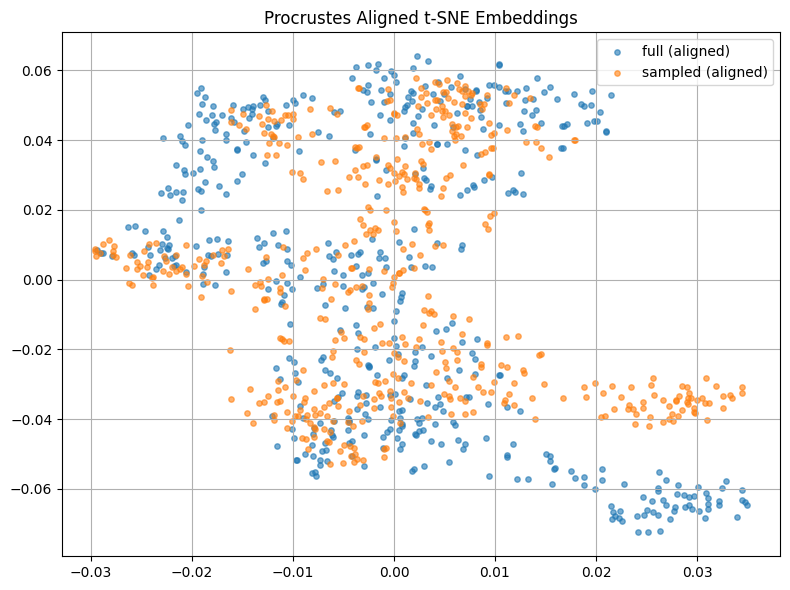

In [31]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE
from scipy.spatial import procrustes

# full / sampled 분리
num_users = len(user_ids)
full_coords = tsne_result[:num_users]
sampled_coords = tsne_result[num_users:]

# ✅ Procrustes 정렬 수행
mtx1, mtx2, disparity = procrustes(full_coords, sampled_coords)
print(f"Procrustes disparity: {disparity:.4f}")

# ✅ Procrustes 결과 시각화
plt.figure(figsize=(8, 6))
plt.scatter(mtx1[:, 0], mtx1[:, 1], label='full (aligned)', alpha=0.6, s=15)
plt.scatter(mtx2[:, 0], mtx2[:, 1], label='sampled (aligned)', alpha=0.6, s=15)
plt.legend()
plt.grid(True)
plt.title("Procrustes Aligned t-SNE Embeddings")
plt.tight_layout()
plt.show()


In [32]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr, pearsonr

# full_embeddings, sampled_embeddings: [N, d] numpy array 라고 가정

# 1. 각 임베딩에 대해 cosine distance matrix 계산
dist_full = squareform(pdist(full_embeddings, metric="cosine"))      # [N, N]
dist_sampled = squareform(pdist(sampled_embeddings, metric="cosine"))  # [N, N]

# 2. upper triangular part만 추출 (중복 제거, 대각 제외)
triu_indices = np.triu_indices_from(dist_full, k=1)
vec_full = dist_full[triu_indices]
vecrmfj_sampled = dist_sampled[triu_indices]

# 3. 상관계수 계산
spearman_r, spearman_p = spearmanr(vec_full, vecrmfj_sampled)
pearson_r, pearson_p = pearsonr(vec_full, vecrmfj_sampled)

# 결과 출력
print(f"Spearman correlation: r = {spearman_r:.4f}, p = {spearman_p:.4g}")
print(f"Pearson correlation : r = {pearson_r:.4f}, p = {pearson_p:.4g}")

Spearman correlation: r = 0.7700, p = 0
Pearson correlation : r = 0.7617, p = 0


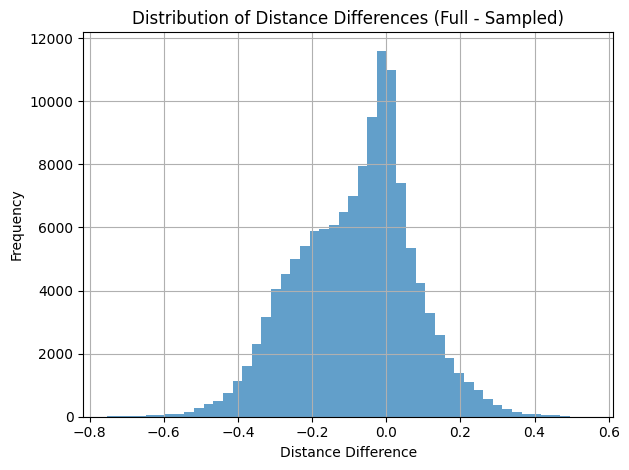

In [33]:
import matplotlib.pyplot as plt

plt.hist(vec_full - vecrmfj_sampled, bins=50, alpha=0.7)
plt.title("Distribution of Distance Differences (Full - Sampled)")
plt.xlabel("Distance Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [34]:
import numpy as np

diff = vec_full - vecrmfj_sampled
mean_diff = np.mean(diff)
std_diff = np.std(diff)
max_diff = np.max(np.abs(diff))

print(f"Mean diff      : {mean_diff:.4f}")
print(f"Std of diff    : {std_diff:.4f}")
print(f"Max |diff|     : {max_diff:.4f}")
print(f"Proportion |diff| < 0.2: {(np.mean(np.abs(diff) < 0.2)):.2%}")


Mean diff      : -0.0822
Std of diff    : 0.1574
Max |diff|     : 0.7524
Proportion |diff| < 0.2: 73.13%


## 75%

100%|██████████| 512/512 [00:00<00:00, 614.89it/s]


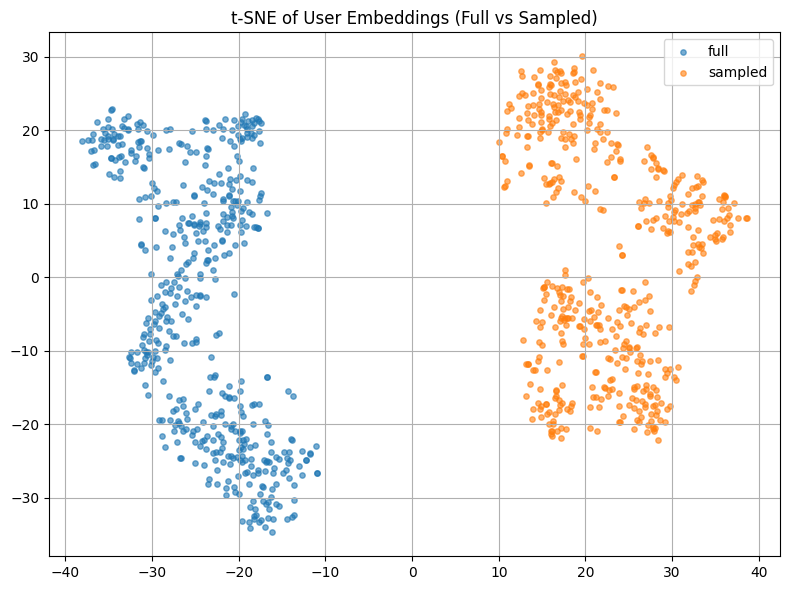

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE

# 경로 설정
full_dir = "/home/users/chaehyun/RS/A-LLMRec/pre_train/sasrec_multi/pos_preprocess/sports75/user_repr"
sampled_dir = "/home/users/chaehyun/RS/A-LLMRec/pre_train/sasrec_multi/sports75/user_repr"

user_files = sorted(os.listdir(full_dir))  # 예: ['123.pt', '456.pt', ...]

full_embeddings = []
sampled_embeddings = []
user_ids = []

for fname in tqdm(user_files):
    full_path = os.path.join(full_dir, fname)
    sampled_path = os.path.join(sampled_dir, fname)

    if not os.path.exists(sampled_path):
        continue

    full_obj = torch.load(full_path, map_location="cuda:7", weights_only=False)
    sampled_obj = torch.load(sampled_path, map_location="cuda:7", weights_only=False)

    full_vec = full_obj["user_repr"].squeeze(0)         # [1, d] -> [d]
    sampled_vec = sampled_obj["user_repr"].squeeze(0)   # [1, d] -> [d]

    full_vec = torch.nn.functional.normalize(full_vec, dim=0)
    sampled_vec = torch.nn.functional.normalize(sampled_vec, dim=0)

    full_embeddings.append(full_vec.cpu().numpy())
    sampled_embeddings.append(sampled_vec.cpu().numpy())
    user_ids.append(fname.split(".")[0])  # 예: "123"

# (2N, d)
all_embeddings = np.vstack([full_embeddings, sampled_embeddings])
labels = ["full"] * len(full_embeddings) + ["sampled"] * len(sampled_embeddings)

# t-SNE로 2D 투영
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(all_embeddings)

# 시각화
plt.figure(figsize=(8, 6))
for label in ["full", "sampled"]:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=label, alpha=0.6, s=15)

plt.title("t-SNE of User Embeddings (Full vs Sampled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


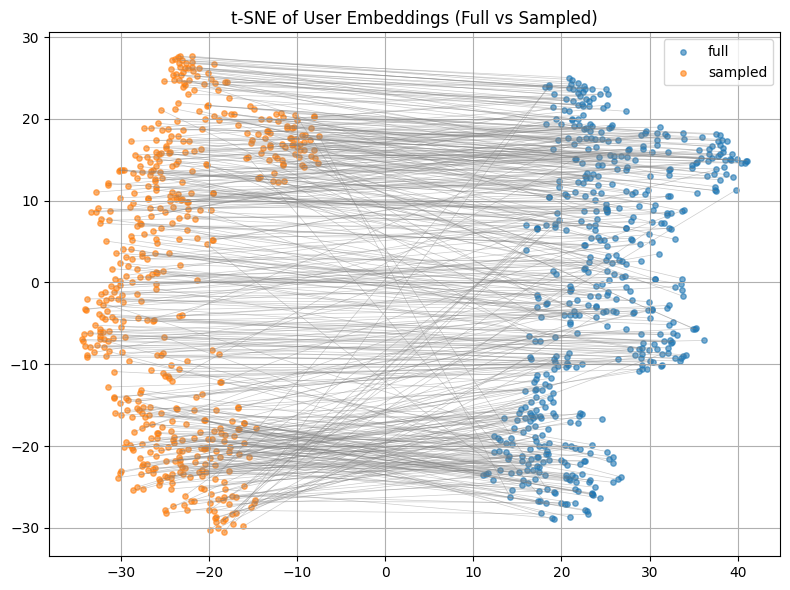

In [2]:
plt.figure(figsize=(8, 6))

# 먼저 scatter
for label in ["full", "sampled"]:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=label, alpha=0.6, s=15)

# 선 연결: 같은 user_id에 대해 full vs sampled 위치를 잇기
num_users = len(user_ids)
for i in range(num_users):
    x_coords = [tsne_result[i, 0], tsne_result[i + num_users, 0]]  # full, sampled
    y_coords = [tsne_result[i, 1], tsne_result[i + num_users, 1]]
    plt.plot(x_coords, y_coords, color="gray", alpha=0.4, linewidth=0.5)

plt.title("t-SNE of User Embeddings (Full vs Sampled)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


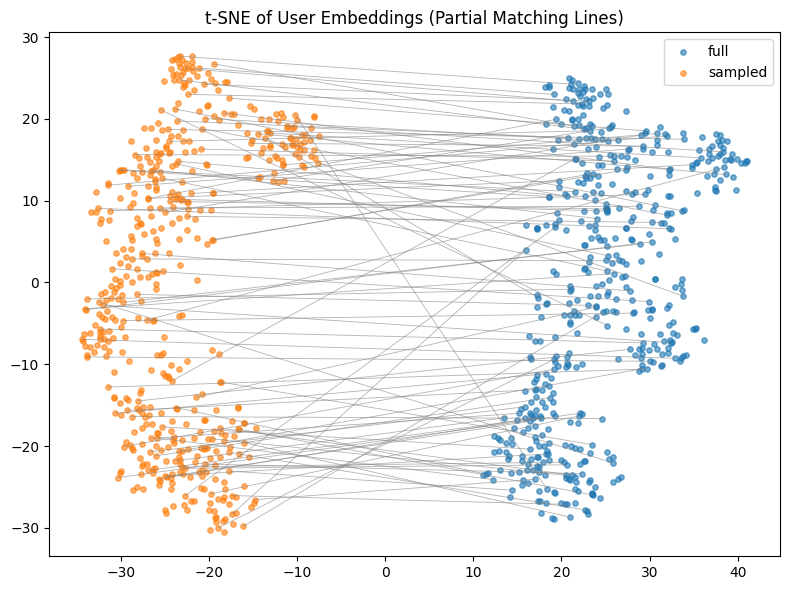

In [3]:
import random

plt.figure(figsize=(8, 6))

# 전체 scatter (full + sampled)
for label in ["full", "sampled"]:
    idx = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=label, alpha=0.6, s=15)

# 선 연결: 일부 유저만
num_users = len(user_ids)
max_lines = 100  # 연결할 유저 수 제한

sampled_indices = random.sample(range(num_users), min(max_lines, num_users))
for i in sampled_indices:
    x_coords = [tsne_result[i, 0], tsne_result[i + num_users, 0]]  # full, sampled
    y_coords = [tsne_result[i, 1], tsne_result[i + num_users, 1]]
    plt.plot(x_coords, y_coords, color="gray", alpha=0.6, linewidth=0.6)

plt.title("t-SNE of User Embeddings (Partial Matching Lines)")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()


Procrustes disparity: 0.4247


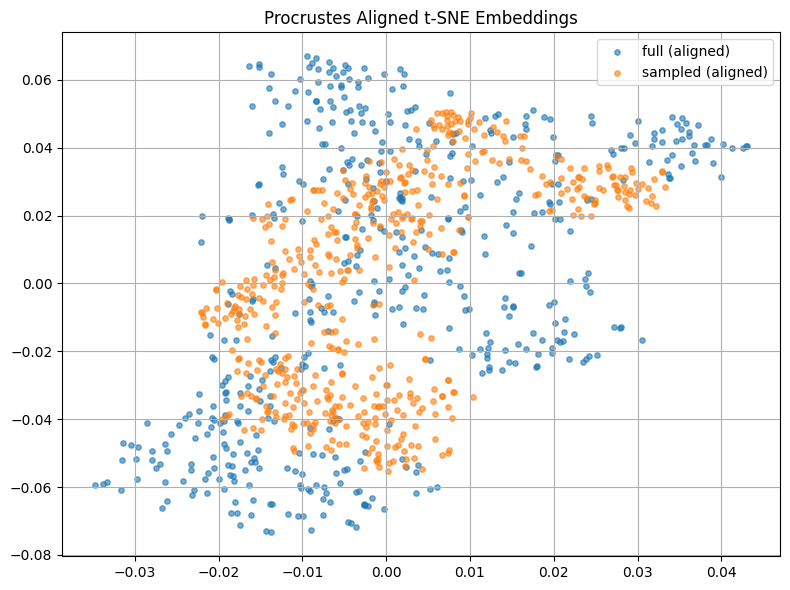

In [4]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE
from scipy.spatial import procrustes

# full / sampled 분리
num_users = len(user_ids)
full_coords = tsne_result[:num_users]
sampled_coords = tsne_result[num_users:]

# ✅ Procrustes 정렬 수행
mtx1, mtx2, disparity = procrustes(full_coords, sampled_coords)
print(f"Procrustes disparity: {disparity:.4f}")

# ✅ Procrustes 결과 시각화
plt.figure(figsize=(8, 6))
plt.scatter(mtx1[:, 0], mtx1[:, 1], label='full (aligned)', alpha=0.6, s=15)
plt.scatter(mtx2[:, 0], mtx2[:, 1], label='sampled (aligned)', alpha=0.6, s=15)
plt.legend()
plt.grid(True)
plt.title("Procrustes Aligned t-SNE Embeddings")
plt.tight_layout()
plt.show()


In [9]:
len(full_embeddings)
full_embeddings[0].shape

(50,)

In [19]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr, pearsonr

# full_embeddings, sampled_embeddings: [N, d] numpy array 라고 가정

# 1. 각 임베딩에 대해 cosine distance matrix 계산
dist_full = squareform(pdist(full_embeddings, metric="cosine"))      # [N, N]
dist_sampled = squareform(pdist(sampled_embeddings, metric="cosine"))  # [N, N]

# 2. upper triangular part만 추출 (중복 제거, 대각 제외)
triu_indices = np.triu_indices_from(dist_full, k=1)
vec_full = dist_full[triu_indices]
vecrmfj_sampled = dist_sampled[triu_indices]

# 3. 상관계수 계산
spearman_r, spearman_p = spearmanr(vec_full, vecrmfj_sampled)
pearson_r, pearson_p = pearsonr(vec_full, vecrmfj_sampled)

# 결과 출력
print(f"Spearman correlation: r = {spearman_r:.4f}, p = {spearman_p:.4g}")
print(f"Pearson correlation : r = {pearson_r:.4f}, p = {pearson_p:.4g}")

Spearman correlation: r = 0.6879, p = 0
Pearson correlation : r = 0.6951, p = 0


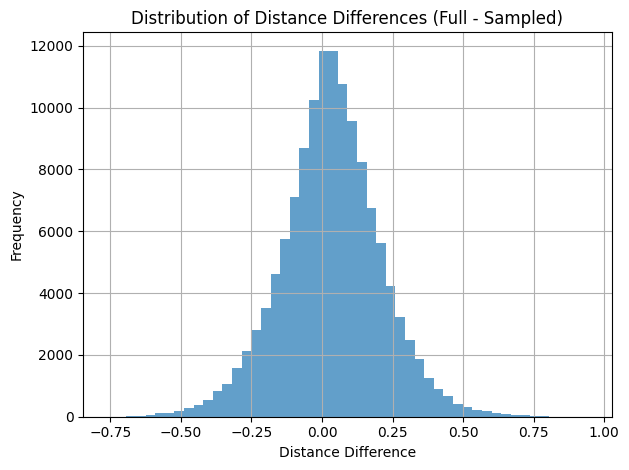

In [20]:
import matplotlib.pyplot as plt

plt.hist(vec_full - vecrmfj_sampled, bins=50, alpha=0.7)
plt.title("Distribution of Distance Differences (Full - Sampled)")
plt.xlabel("Distance Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
import numpy as np

diff = vec_full - vecrmfj_sampled
mean_diff = np.mean(diff)
std_diff = np.std(diff)
max_diff = np.max(np.abs(diff))

print(f"Mean diff      : {mean_diff:.4f}")
print(f"Std of diff    : {std_diff:.4f}")
print(f"Max |diff|     : {max_diff:.4f}")
print(f"Proportion |diff| < 0.2: {(np.mean(np.abs(diff) < 0.2)):.2%}")


Mean diff      : 0.0325
Std of diff    : 0.1772
Max |diff|     : 0.9413
Proportion |diff| < 0.2: 75.50%


In [5]:
import torch
path = '/home/users/chaehyun/RS/A-LLMRec/pre_train/sasrec_multi/sports100/txt_features/1881509818.pth'
data = torch.load(path, map_location="cuda:7", weights_only=False)

print(type(data))
print(data)

<class 'torch.Tensor'>
tensor([ 1.2817e-02, -7.5684e-02,  1.4954e-02,  8.1787e-03, -6.5918e-02,
         4.8828e-02,  3.4912e-02, -5.7602e-04,  4.4189e-02, -1.0437e-02,
         3.8574e-02,  5.2734e-02,  1.7700e-02,  4.3213e-02,  1.0254e-02,
         4.4922e-02, -6.1035e-03,  4.1992e-02, -1.0254e-01, -3.5400e-03,
         3.1738e-02, -7.8964e-04, -1.9287e-02,  5.8105e-02,  6.7749e-03,
         1.2085e-02, -2.1240e-02,  1.2939e-02,  5.1270e-03, -1.6174e-03,
         1.4404e-02,  4.9438e-03, -8.3008e-03,  8.3496e-02,  1.6838e-06,
         1.2756e-02,  5.4688e-02,  2.4414e-02, -4.2419e-03,  2.6001e-02,
        -3.3203e-02, -3.0884e-02, -6.6833e-03,  3.5645e-02, -1.5320e-02,
        -3.1982e-02,  3.6316e-03,  1.6708e-03, -3.1738e-02, -3.1738e-02,
        -1.7578e-02, -7.7148e-02,  5.6885e-02, -8.0566e-02,  1.3306e-02,
         6.0547e-02, -2.8076e-02,  3.4912e-02,  1.3794e-02,  6.1279e-02,
         1.5991e-02,  7.5684e-03, -2.2095e-02,  1.0376e-02,  1.7090e-03,
        -7.9346e-03,  1.4160

## 전체

Loading embeddings: 100%|██████████| 4/4 [00:00<00:00,  6.91it/s]


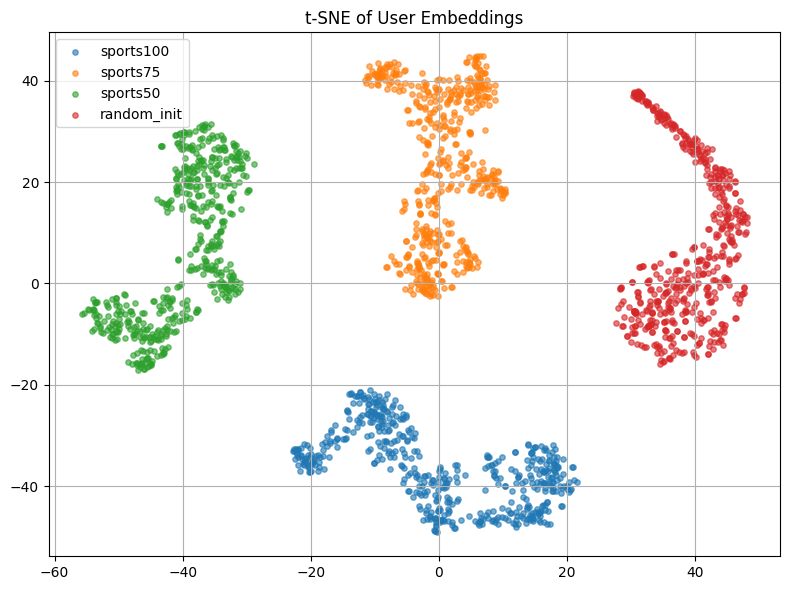

In [6]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr, pearsonr

# 경로 및 레이블 설정
dirs = [
    ("/home/users/chaehyun/RS/A-LLMRec/pre_train/sasrec_multi/sports100/user_repr_result", "sports100"),
    ("/home/users/chaehyun/RS/A-LLMRec/pre_train/sasrec_multi/sports75/user_repr_result", "sports75"),
    ("/home/users/chaehyun/RS/A-LLMRec/pre_train/sasrec_multi/sports/user_repr_result", "sports50"),
    ("/home/users/chaehyun/RS/A-LLMRec/pre_train/sasrec_multi/sports_random_init/user_repr_result", "random_init")
]

# 모든 디렉토리에 공통으로 존재하는 사용자 파일 찾기
user_files_sets = [set(os.listdir(d[0])) for d in dirs]
common_user_files = sorted(list(set.intersection(*user_files_sets)))

# 임베딩 로드
all_embeddings = []
all_labels = []
embeddings_dict = {}

for dir_path, label in tqdm(dirs, desc="Loading embeddings"):
    current_embeddings = []
    for fname in common_user_files:
        file_path = os.path.join(dir_path, fname)
        obj = torch.load(file_path, map_location="cpu", weights_only=False) # CPU로 로드
        vec = obj["user_repr"].squeeze(0)
        vec = torch.nn.functional.normalize(vec, dim=0)
        current_embeddings.append(vec.numpy())

    embeddings_dict[label] = np.array(current_embeddings)
    all_embeddings.extend(current_embeddings)
    all_labels.extend([label] * len(current_embeddings))

# t-SNE로 2D 투영
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(np.array(all_embeddings))

# 시각화
plt.figure(figsize=(8, 6))
start_idx = 0
for dir_path, label in dirs:
    num_embeddings = len(embeddings_dict[label])
    end_idx = start_idx + num_embeddings
    plt.scatter(tsne_result[start_idx:end_idx, 0], tsne_result[start_idx:end_idx, 1], label=label, alpha=0.6, s=15)
    start_idx = end_idx

plt.title("t-SNE of User Embeddings")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

--- Correlation Analysis with sports100 ---

Comparing with: sports75
Spearman correlation: r = 0.7700, p = 0
Pearson correlation : r = 0.7617, p = 0


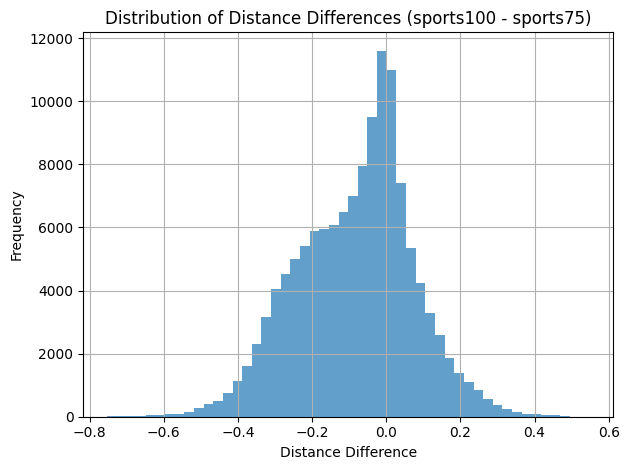


2. Statistics of Distance Differences (sports100 - sports75):
   - Mean diff        : -0.0822
   - Std of diff      : 0.1574
   - Max |diff|       : 0.7524
   - Proportion of |diff| < 0.2: 73.13%

Comparing with: sports50
Spearman correlation: r = 0.8048, p = 0
Pearson correlation : r = 0.7997, p = 0


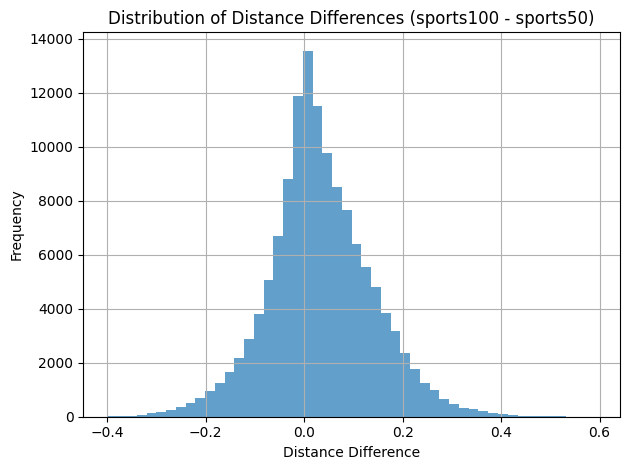


2. Statistics of Distance Differences (sports100 - sports50):
   - Mean diff        : 0.0330
   - Std of diff      : 0.1058
   - Max |diff|       : 0.5919
   - Proportion of |diff| < 0.2: 92.05%

Comparing with: random_init
Spearman correlation: r = 0.1508, p = 0
Pearson correlation : r = 0.1657, p = 0


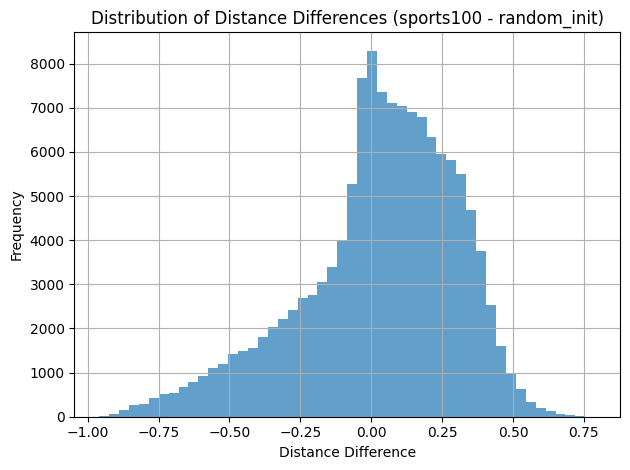


2. Statistics of Distance Differences (sports100 - random_init):
   - Mean diff        : 0.0285
   - Std of diff      : 0.2757
   - Max |diff|       : 0.9596
   - Proportion of |diff| < 0.2: 52.44%


In [9]:
# 상관관계 계산
base_embeddings = embeddings_dict["sports100"]
dist_base = squareform(pdist(base_embeddings, metric="cosine"))
triu_indices = np.triu_indices_from(dist_base, k=1)
vec_base = dist_base[triu_indices]

print("--- Correlation Analysis with sports100 ---")
for label, embeddings in embeddings_dict.items():
    if label == "sports100":
        continue

    # 비교 대상의 거리 벡터 계산
    dist_comparison = squareform(pdist(embeddings, metric="cosine"))
    vec_comparison = dist_comparison[triu_indices]

    # 1. 상관관계 계산 및 출력
    spearman_r, spearman_p = spearmanr(vec_base, vec_comparison)
    pearson_r, pearson_p = pearsonr(vec_base, vec_comparison)

    print(f"\nComparing with: {label}")
    print(f"Spearman correlation: r = {spearman_r:.4f}, p = {spearman_p:.4g}")
    print(f"Pearson correlation : r = {pearson_r:.4f}, p = {pearson_p:.4g}")

    # 2. 거리 차이 분포 히스토그램 생성 및 저장
    plt.figure() # 새 Figure 객체 생성
    plt.hist(vec_base - vec_comparison, bins=50, alpha=0.7)
    plt.title(f"Distribution of Distance Differences (sports100 - {label})")
    plt.xlabel("Distance Difference")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    diff = vec_base - vec_comparison
    mean_diff = np.mean(diff)
    std_diff = np.std(diff)
    max_diff = np.max(np.abs(diff))
    
    print("\n2. Statistics of Distance Differences (sports100 - {}):".format(label))
    print(f"   - Mean diff        : {mean_diff:.4f}")
    print(f"   - Std of diff      : {std_diff:.4f}")
    print(f"   - Max |diff|       : {max_diff:.4f}")
    print(f"   - Proportion of |diff| < 0.2: {(np.mean(np.abs(diff) < 0.2)):.2%}")
